## 逻辑回归示例

1. 逻辑回归
2. 向量化计算
3. 正则化逻辑回归


In [2]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)

#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')




加载数据

输入：文件名，分隔符

输出：np.array类型的数据

In [1]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ',data.shape)
    print(data[1:6,:])
    return(data)

In [5]:
def plotData(data,label_x,label_y,label_pos,label_neg,axes=None):
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    
    if axes == None:
        axes = plt.gca()
    
    axes.scatter(data[pos][:,0],data[pos][:,1],marker='+',c='k',s=60,label=label_x)
    axes.scatter(data[neg][:,0],data[neg][:,1],c='y',s=60,label=label_y)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon=True,fancybox=True)
    

加载原始数据

X: 100*2

Y: 100*1

In [10]:
data = loaddata('./data/data1.txt',',')

('Dimensions: ', (100L, 3L))
[[ 30.28671077  43.89499752   0.        ]
 [ 35.84740877  72.90219803   0.        ]
 [ 60.18259939  86.3085521    1.        ]
 [ 79.03273605  75.34437644   1.        ]
 [ 45.08327748  56.31637178   0.        ]]


train_x 加上一列：1

(100L, 3L)
(100L, 1L)


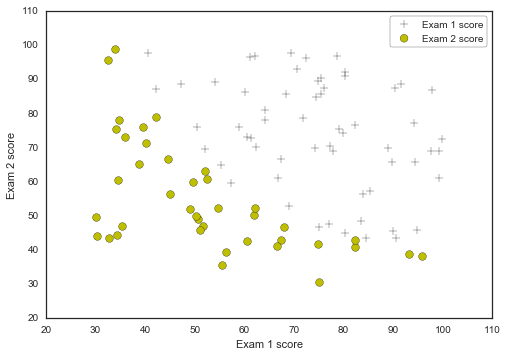

In [16]:
X = np.c_[np.ones((data.shape[0],1)),data[:,0:2]]
Y = np.c_[data[:,2]]
print X.shape
print Y.shape

plotData(data, 'Exam 1 score', 'Exam 2 score', 'Pass', 'Fail')



#### 逻辑回归假设
$$ h_{\theta}(x)=g({\theta^T}x)$$
$$ g(z)=\frac{1}{1+e^{-z}} $$

sigmoid函数把数值压缩到[0,1]，因此在二分类问题中
\\(h_{\theta}(x)\\)
可以表示预测为正例的概率。同时
\\(\theta*X\\)
确定了决策边界，若其为线性函数，则为线性判定边界，为非线性函数，则生成非线性判定边界。


In [17]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

### 损失函数
假设损失函数为均方误差函数，即
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2$$
改函数为非凸函数，求解时不方便。因此设计如下(最大似然估计)代价函数：

\begin{eqnarray}Cost(h_{\theta}(x),y)=
\begin{cases}
-log{(h_\theta(x))}, &y=1
\cr -log{(1-h_\theta(x))}, &y=0 \end{cases}
\end{eqnarray}

该函数把[0,1]之间的值放大到[1,∞]，当
\\(h_{\theta}(x)\\)

比较小时，
\\(-log{(h_\theta(x))}\\)较大，反之亦然。
当y=0是，相反。

分段函数组合到一起，构成逻辑回归的损失函数：

$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))+(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$

向量化的损失函数（矩阵形式）：

$$
J(\theta) = -\frac{1}{m}\big((\,log\,(g(X\theta)^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big)
$$

其中X为特征矩阵，表示有M个观测样本，每个样本N个属性，每一行代表一个样本，
\\(\theta\\) 为 N维列向量，y为M维列向量，\\(g(X\theta)\\)为M维列向量


In [176]:
#定义损失函数
def costFunction(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    left = np.log(h).T.dot(y)
    right = np.log(1-h).T.dot(1-y)
    J = -1.0*(1.0/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) 
    if np.isnan(J[0]):
        return(10000)
    return J[0]

#### 求偏导(梯度)

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 
#### 向量化的偏导(梯度)
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$

梯度下降算法

theta 怎么改？可变类型

In [166]:
def gradientDesc(theta,X,Y,alpha=0.0001,iterations=200000):
    m = Y.shape[0]
    Js = []
    Js.append(costFunction(theta,X,Y))
    thetas = []
    thetas.append(theta)
    for i in range(iterations):
        h = sigmoid(X.dot(theta))
        grad = (1.0/m) * (X.T.dot(h-Y))
        theta = theta - alpha * grad
        thetas.append(theta)        
        Js.append(costFunction(theta,X,Y))
    return thetas,Js


In [179]:
#求解梯度
def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    
    grad =(1.0/m)*X.T.dot(h-y)

    return(grad.flatten())

In [177]:
# theta N*1 维列向量
init_theta = np.zeros((X.shape[1],1))
cost = costFunction(init_theta,X,Y)
thetas,Js  = gradientDesc(init_theta,X,Y)
print 'Cost: ', Js[-1]
print 'theta: ', thetas[-1]




Cost:  [ 0.54729609]
theta:  [[-1.28300143]
 [ 0.01942352]
 [ 0.01046413]]


使用scipy.optimize中的minimize函数进行优化


In [184]:
res = minimize(costFunction, init_theta, args=(X,Y), jac=gradient, options={'maxiter':4000})
print res['x']

[-25.16132482   0.20623166   0.20147152]


预测
第一次成绩45，第二次成绩85 的同学通过的概率多高

In [188]:
def predict(theta,X,threshold=0.5):
    p = sigmoid(X.dot(theta))
    return p

print predict(thetas[-1],np.array([1,45,85]))
print predict(res['x'],np.array([1,45,85]))

[ 0.6178679]
0.776290607122


画出决策边界

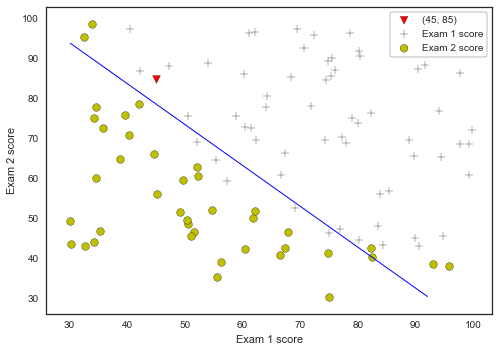

In [189]:
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(res.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

# 正则化的LR

In [357]:
data2 = loaddata("./data/data2.txt",',')

('Dimensions: ', (118L, 3L))
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [355]:
X = np.c_[data[:,0:2]]
Y = np.c_[data[:,2]]

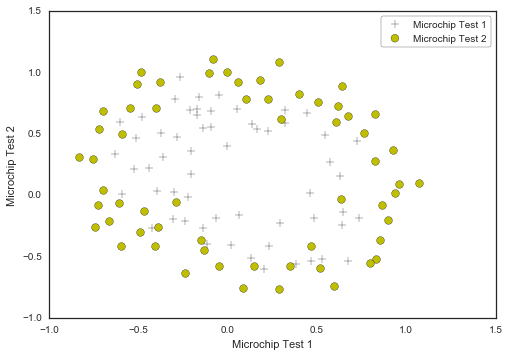

In [356]:
plotData(data2,'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')


多项式特征

from sklearn.preprocessing import PolynomialFeatures

PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)


In [354]:
poly = PolynomialFeatures(degree=6,interaction_only=False)
XX = poly.fit_transform(X)
print poly.n_output_features_


28


正则化后的损失函数

$$J(\theta) = \frac{1}{m}\sum_{i=1}^m\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]+\frac{\lambda}{2m}\sum_{j=1}^n\theta_{j}^2$$

向量化损失函数

$$J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}
$$

In [362]:
def costFunctionReg(theta,reg,XX,Y):
    m = Y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1.0*(1.0/m)*(np.log(h).T.dot(Y)+np.log(1-h).T.dot(1-Y)) + (reg/(2.0*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

### 梯度

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### 向量化的偏导(梯度)
#### $$ \frac{\delta J(\theta)}{\delta\theta} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta$$
##### $$\text{注意，我们另外自己加的参数 } \theta_{0} \text{ 不需要被正则化}$$

In [337]:
def gradientDescReg(theta,reg,XX,Y,alpha=0.0001,iterations=20000):
    m = Y.shape[0]
    Js = []
    Js.append(costFunctionReg(theta,reg,XX,Y))
    thetas = []
    thetas.append(theta)
    for i in range(iterations):
        h = sigmoid(XX.dot(theta))
        grad = (1.0/m) * (XX.T.dot(h-Y)) + (reg/m) * np.r_[[[0]],theta[1:].reshape(-1,1)]
        theta = theta - alpha * grad
        thetas.append(theta)  
        Js.append(costFunctionReg(theta,reg,XX,Y))
    return thetas,Js

In [350]:
def gradientReg(theta, reg, *args):
    m = Y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1.0/m)*XX.T.dot(h-Y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [363]:
# theta N*1 维列向量
init_theta = np.zeros((XX.shape[1],1))
cost = costFunctionReg(init_theta,1,XX,Y)
# thetas,Js = gradientDescReg(init_theta,100,XX,Y,alpha=0.01)
# grad = gradientReg(init_theta,100,XX,Y)
# print 'Cost: ', Js[-1]
# print 'theta: ', thetas[-1]
# print "grad",grad
print 'Cost: ', cost

Cost:  [ 0.69314718]


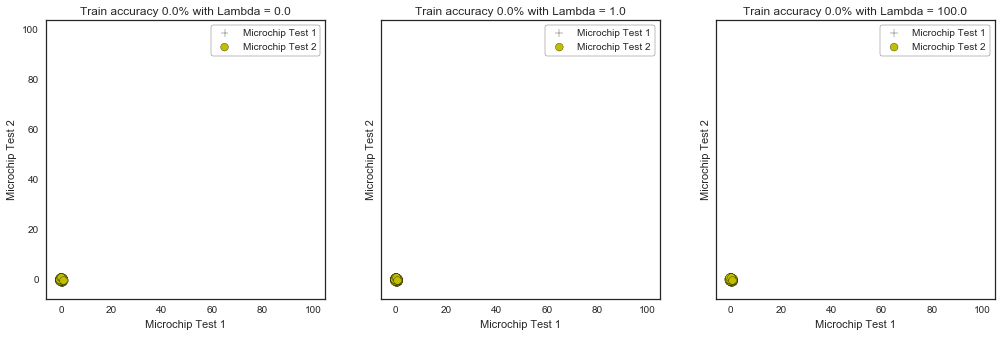

In [364]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# 决策边界，咱们分别来看看正则化系数lambda太大太小分别会出现什么情况
# Lambda = 0 : 就是没有正则化，这样的话，就过拟合咯
# Lambda = 1 : 这才是正确的打开方式
# Lambda = 100 : 卧槽，正则化项太激进，导致基本就没拟合出决策边界

for i, C in enumerate([0.0, 1.0, 100.0]):
    # 最优化 costFunctionReg
    res2 = minimize(costFunctionReg, init_theta, args=(C, XX, Y), jac=gradientReg, options={'maxiter':3000})
    
    # 准确率
    accuracy = 100.0*sum(predict(res2.x, XX) == Y.ravel())/Y.size    

    # 对X,y的散列绘图
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # 画出决策边界
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g');       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))